In [1]:
%load_ext autoreload

In [2]:
%matplotlib inline

In [3]:
%autoreload

In [4]:
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

In [5]:
import pandas as pd
import flora_tools.lwb_slot as lwb_slot
from flora_tools.lwb_slot import LWBSlot

payloads = [8, 16, 32, 64, 128, 255]

payload_strings = [str(i) for i in payloads]

## Ack Slot Formula

#### Glossy without adaptions:

$$ E_\mathrm{Total} = N \cdot r \cdot (E_\mathrm{Rx} + E_\mathrm{Tx}) - E_\mathrm{Rx} $$

$$ E_\mathrm{Total} = N \cdot r \cdot (\frac{N \cdot r - 1}{N \cdot r} E_\mathrm{Rx} + E_\mathrm{Tx}) $$

where $r$ is the retransmission rate and $N$ is the number of nodes. The preamble detection power is not accounted for.

#### Glossy with ACK

Given 

$$ E_\mathrm{Rx,Ack} = \alpha \cdot E_\mathrm{Rx} $$

and

$$ E_\mathrm{Tx,Ack} = \alpha \cdot E_\mathrm{Tx} $$

and assuming that all packages receive their destined nodes at the first chance. The acknowledgement is only resent once after its reception.

We consider each node $n_i$ by itself. The crucial term for describing when a node $n_i$ is interrupted by the Ack is given by the difference in arrival time of the source's package and the destination's Ack ($l$ for latency):

$$ l(n_i) = \max(0, (d(n_\text{src}, n_\text{dst}) - 1) + \max(d(n_\text{dst}, n_i), 1) - (d(n_\text{src}, n_i) - 1)) \\
= \max(0, d(n_\text{src}, n_\text{dst}) + \max(d(n_\text{dst}, n_i), 1) - d(n_\text{src}, n_i))$$

The upper bound total slot count can be approximated by

$$ |S_{\mathrm{Rx}_{n_i}}| = \min(\text{ceil}(\frac{l(n_i)}{2}), r) $$

$$ |S_{\mathrm{Tx}_{n_i}}| = \text{floor}(\frac{l(n_i)}{2}) $$

$$ |S_{\mathrm{Tx,Ack}_{n_i}}| = H( 2 \cdot r - l(n_i) - 1) $$

$$ |S_{\mathrm{Rx,Ack}_{n_i}}| = H( 2 \cdot r - l(n_i) - 2) $$

where $H(x)$ is the Heaviside function.

Special adaptions for a better approximation are the source node itself which has one Rx slot less and therefore has to be regarded seperately in the summation. If a node has a precessor which was acked directly after a Rx slot, the regarding child node will save one Rx slot.


$$ E_\mathrm{Total} = \sum_{n_i} ( |S_{\mathrm{Rx}_{n_i}}| \cdot E_\mathrm{Rx}\\
+ |S_{\mathrm{Tx}_{n_i}}| \cdot E_\mathrm{Tx}\\
+ |S_{\mathrm{Rx,Ack}_{n_i}}| \cdot E_\mathrm{Rx,Ack}\\
+ |S_{\mathrm{Tx,Ack}_{n_i}}| \cdot E_\mathrm{Tx,Ack} )\\
- E_\mathrm{Rx}$$


##### Complete Graph Topology (best case)

Every node reaches every other node in one hop.

$$ E_\mathrm{Total} = E_\mathrm{Tx} + (N - 1) \cdot E_\mathrm{Rx} + E_\mathrm{Tx-Ack} + (N - 1) \cdot E_\mathrm{Rx-Ack}\\
= (1 + \alpha) \cdot E_\mathrm{Tx} + (1 + \alpha) \cdot (N - 1) \cdot E_\mathrm{Rx}$$

##### No reception of ACK (worst case)

The target node receives the message, but its Acknowledgement does not get received by any node. All other $N - 1$ nodes therefore retransmit the package wastefuly.

$$ E_\mathrm{Total} = (N - 1) \cdot r \cdot (E_\mathrm{Rx} + E_\mathrm{Tx} + 2 \cdot E_\mathrm{Ack_\mathrm{Rx}}) - (E_\mathrm{Rx} + E_\mathrm{Ack_\mathrm{Rx}})\\
+ (E_\mathrm{Rx} + E_\mathrm{Ack_\mathrm{Tx}}) $$

$$ = (N - 1) \cdot r \cdot ((1 + 2\alpha - \frac{\alpha}{(N-1)r}) \cdot E_\mathrm{Rx} + (1 + \frac{\alpha}{(N-1)r}) \cdot E_\mathrm{Tx}) $$

For high node counts, worst case and vanilla Glossy converge, with the Acknowledgements having $2\alpha$ overhead.

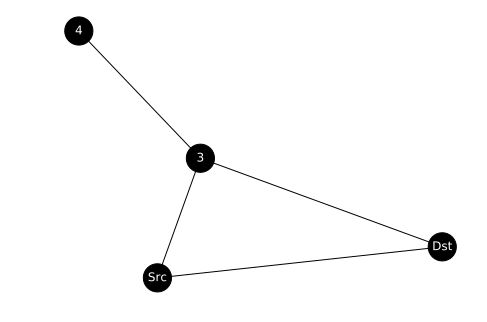

In [6]:
import matplotlib.pyplot as plt
import networkx as nx

%config InlineBackend.figure_format = 'svg'

G = nx.Graph()

plt.figure()

G.add_nodes_from(["Src", "Dst", "3", "4"])
G.add_edges_from([("Src", "Dst"), ("Src", "3"), ("Dst", "3"), ("3", "4")])

nx.draw(G, node_size=800, with_labels=True, node_color='k',  font_color='white')

plt.show()

Node 4 will not require a Rx slot.

In [7]:
columns = ["Gloria Modulation"]
columns.extend(payload_strings)

lwb_slot_time = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.RADIO_MODULATIONS)):
    item = [lwb_slot.RADIO_MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        
        total_time = slot.flood.slots[0].slot_time
        
        item.append(total_time)
    lwb_slot_time.loc[i] = item

lwb_slot_time.style


,Gloria Modulation,8,16,32,64,128,255
0,3,0.19924,0.2402,0.32212,0.46548,0.7522,1.32564
1,5,0.0573488,0.0727088,0.0931888,0.139269,0.236549,0.420869
2,7,0.0193914,0.0232314,0.0309114,0.0475514,0.0808314,0.146111
3,9,0.00305338,0.00337338,0.00401338,0.00529338,0.00785338,0.0129334


In [8]:
to_timer_ticks = lambda x: int(x * 8E6)

lwb_slot_time.applymap(to_timer_ticks)

,Gloria Modulation,8,16,32,64,128,255
0,24000000,1593919,1921599,2576959,3723839,6017599,10605119
1,40000000,458790,581670,745510,1114150,1892390,3366950
2,56000000,155131,185851,247291,380411,646651,1168891
3,72000000,24427,26987,32107,42347,62827,103467


### Gloria Flood Energy

In [9]:
lwb_slot_energy = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.RADIO_MODULATIONS)):
    item = [lwb_slot.RADIO_MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        gloria_flood_energy = slot.flood.energy
        
        item.append(gloria_flood_energy)
    lwb_slot_energy.loc[i] = item

lwb_slot_energy.style

,Gloria Modulation,8,16,32,64,128,255
0,3,3.94412,4.66051,6.0933,8.60066,13.6154,23.6449
1,5,24.2729,31.8051,41.8481,64.4448,112.149,202.536
2,7,8.40323,10.3535,14.2539,22.7049,39.6068,72.7605
3,9,0.642408,0.804926,1.12996,1.78004,3.08018,5.66016


In [10]:
lwb_slot_energy_per_byte = lwb_slot_energy
battery_energy = 12000 * 3600 * 3.7 # 12'000 mAh

for i in range(len(lwb_slot.RADIO_MODULATIONS)):
    for j in payloads:
        lwb_slot_energy_per_byte.loc[i,str(j)] /= j

battery_energy / lwb_slot_energy_per_byte

,Gloria Modulation,8,16,32,64,128,255
0,5.328000e+07,3.242089e+08,5.487463e+08,8.394276e+08,1.189415e+09,1.502676e+09,1.723808e+09
1,3.196800e+07,5.268102e+07,8.040971e+07,1.222249e+08,1.587368e+08,1.824316e+08,2.012444e+08
2,2.283429e+07,1.521700e+08,2.470132e+08,3.588408e+08,4.505539e+08,5.165663e+08,5.601829e+08
3,1.776000e+07,1.990511e+09,3.177235e+09,4.526590e+09,5.746938e+09,6.642305e+09,7.201064e+09


Shown is total amount of Bytes being able to be sent, respectively processed by a single node for
a given payload length and Gloria Modulation Index. The total amount is smaller for
SF7 than SF9 due to the retransmission and hop count being larger (2, rather than 1 respectively),
and by incorporating the fact that, we do not account for the first transmission from the base.

We can therefore send approximately ~ 7 GB of data (FSK 200 kBit/s, 255 Bytes, 12000 mAh @ 3.7 Volts, 10mW TX)

32 Byte datapoint:

In [11]:
battery_energy / lwb_slot_energy_per_byte / 100 / 32

,Gloria Modulation,8,16,32,64,128,255
0,16650.000000,101315.274263,171483.218269,2.623211e+05,3.716923e+05,4.695861e+05,5.386900e+05
1,9990.000000,16462.819945,25128.034772,3.819529e+04,4.960524e+04,5.700988e+04,6.288888e+04
2,7135.714286,47553.115293,77191.617945,1.121378e+05,1.407981e+05,1.614270e+05,1.750572e+05
3,5550.000000,622034.713629,992885.960517,1.414559e+06,1.795918e+06,2.075720e+06,2.250333e+06


### Speed

In [12]:
lwb_slot_bitrate = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.MODULATIONS)):
    item = [lwb_slot.RADIO_MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=False)
        gloria_flood_bitrate = slot.flood.bitrate
        
        item.append(gloria_flood_bitrate)
    lwb_slot_bitrate.loc[i] = item

lwb_slot_bitrate.style

AttributeError: module 'flora_tools.lwb_slot' has no attribute 'MODULATIONS'

## Gloria Slot + Gloria ACK Timings

In [ ]:
columns = ["Gloria Modulation"]
columns.extend(payload_strings)

lwb_slot_time = pd.DataFrame(columns=columns)

for i in range(len(lwb_slot.RADIO_MODULATIONS)):
    item = [lwb_slot.MODULATIONS[i]]
    for j in payloads:
        slot = LWBSlot.create_empty_slot(i, payload=j, acked=True)
        
        total_time = slot.total_time
        
        item.append(total_time)
    lwb_slot_time.loc[i] = item

lwb_slot_time.style


In [ ]:
to_timer_ticks = lambda x: int(x * 8E6)

lwb_slot_time.applymap(to_timer_ticks)